In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras import layers
from keras.regularizers import l2
import matplotlib.pyplot as plt
import requests
from io import StringIO
import warnings
warnings.filterwarnings("ignore")

In [ ]:
url = 'https://dl.dropboxusercontent.com/s/jm9lb705vk5itk9/Reviews.csv'
response = requests.get(url)

if response.status_code == 200:
    csv_data = response.content.decode('utf-8')
    rawData = pd.read_csv(StringIO(csv_data), engine='python')
else:
    print(f"Error downloading the file: {response.status_code}")

In [ ]:
rawData.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
# Will only include relevant columns
data = rawData[['UserId', 'ProductId', 'Score']]

In [ ]:
#Preprocessing
user_encoder = LabelEncoder()
product_encoder = LabelEncoder()

data['UserId'] = user_encoder.fit_transform(data['UserId'])
data['ProductId'] = product_encoder.fit_transform(data['ProductId'])
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

#Training
user_ids_train = train_data['UserId'].values
item_ids_train = train_data['ProductId'].values
labels_train = train_data['Score'].values / 5.0

#Test
user_ids_test = test_data['UserId'].values
item_ids_test = test_data['ProductId'].values
labels_test = test_data['Score'].values / 5.0

num_users = len(user_encoder.classes_)
num_items = len(product_encoder.classes_)

In [ ]:
class NeuMF(tf.keras.Model):
    def __init__(self, num_users, num_items, latent_dim_gmf, latent_dim_mlp, layers_mlp):
        super(NeuMF, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.latent_dim_gmf = latent_dim_gmf
        self.latent_dim_mlp = latent_dim_mlp

        self.user_embedding_gmf = layers.Embedding(num_users, latent_dim_gmf, name='user_embedding_gmf')
        self.item_embedding_gmf = layers.Embedding(num_items, latent_dim_gmf, name='item_embedding_gmf')

        self.user_embedding_mlp = layers.Embedding(num_users, latent_dim_mlp, name='user_embedding_mlp')
        self.item_embedding_mlp = layers.Embedding(num_items, latent_dim_mlp, name='item_embedding_mlp')

        self.mlp_layers = [layers.Dense(layer, activation='relu') for layer in layers_mlp]

        self.final_layer = layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        user_indices, item_indices = inputs

        # GMF part
        user_latent_gmf = self.user_embedding_gmf(user_indices)
        item_latent_gmf = self.item_embedding_gmf(item_indices)
        gmf_output = tf.multiply(user_latent_gmf, item_latent_gmf)

        # MLP part
        user_latent_mlp = self.user_embedding_mlp(user_indices)
        item_latent_mlp = self.item_embedding_mlp(item_indices)
        mlp_input = tf.concat([user_latent_mlp, item_latent_mlp], axis=-1)

        for layer in self.mlp_layers:
            mlp_input = layer(mlp_input)
        mlp_output = mlp_input

        # NeuMF part
        neumf_input = tf.concat([gmf_output, mlp_output], axis=-1)
        neumf_output = self.final_layer(neumf_input)

        return neumf_output

In [ ]:
latent_dim_gmf = 8
latent_dim_mlp = 16
layers_mlp = [32, 16, 8]

# Define RMSE
def root_mean_squared_error(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true * 5.0 - y_pred * 5.0)))

model = NeuMF(num_users, num_items, latent_dim_gmf, latent_dim_mlp, layers_mlp)

model.compile(optimizer=tf.keras.optimizers.Adam(), loss=root_mean_squared_error)
# Training
history = model.fit([user_ids_train, item_ids_train], labels_train, batch_size=128, epochs=4, validation_split=0.2)


Epoch 1/4
2843/2843 [==============================] - 23s 7ms/step - loss: 1.2048 - val_loss: 1.0999
Epoch 2/4
2843/2843 [==============================] - 17s 6ms/step - loss: 0.7756 - val_loss: 1.0844
Epoch 3/4
2843/2843 [==============================] - 16s 6ms/step - loss: 0.5233 - val_loss: 1.0939
Epoch 4/4
2843/2843 [==============================] - 16s 5ms/step - loss: 0.3765 - val_loss: 1.0896


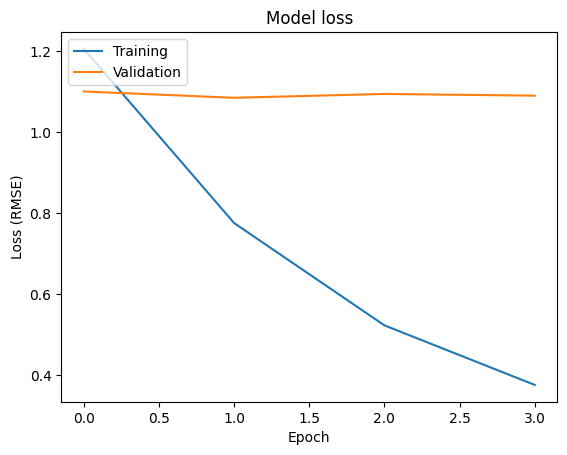

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss (RMSE)')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

In [ ]:
test_loss = model.evaluate([user_ids_test, item_ids_test], labels_test)

print(f"Test loss: {test_loss}")

3553/3553 [==============================] - 8s 2ms/step - loss: 1.0662
Test loss: 1.0661903619766235


In [ ]:
predictions = model.predict([user_ids_test, item_ids_test])
predictions = np.squeeze(predictions) * 5.0  # Scale back

# Prediction results
for i in range(50):
    print(f"User {user_encoder.inverse_transform([user_ids_test[i]])[0]}, "
          f"Item {product_encoder.inverse_transform([item_ids_test[i]])[0]}, "
          f"True Rating: {test_data.iloc[i]['Score']}, "
          f"Predicted Rating: {predictions[i]:.1f}")

3553/3553 [==============================] - 6s 2ms/step
User A1L01D2BD3RKVO, Item B000EVG8J2, True Rating: 5, Predicted Rating: 4.7
User A3U62RE5XZDP0G, Item B0000BXJIS, True Rating: 5, Predicted Rating: 5.0
User AOXC0JQQZGGB6, Item B008FHUFAU, True Rating: 3, Predicted Rating: 3.0
User A3PWPNZVMNX3PA, Item B006BXV14E, True Rating: 2, Predicted Rating: 2.9
User A1XNZ7PCE45KK7, Item B007I7Z3Z0, True Rating: 5, Predicted Rating: 4.9
User A1XWK6ZWTW4C3B, Item B000FKMNSM, True Rating: 4, Predicted Rating: 3.4
User A1ZXQSWCMQ74PV, Item B000XEV9YE, True Rating: 5, Predicted Rating: 4.1
User AKUB840XVHT3, Item B000F4H5FO, True Rating: 5, Predicted Rating: 4.7
User A1FPQ54AIB26L0, Item B0041CIR62, True Rating: 4, Predicted Rating: 4.5
User A1LKBZ7U9DSF4K, Item B001LQRKC8, True Rating: 5, Predicted Rating: 4.8
User AR3EVUQF0AC7R, Item B005VOOL00, True Rating: 4, Predicted Rating: 4.0
User A14AZWOLGK6MD3, Item B000KY6NQG, True Rating: 5, Predicted Rating: 4.9
User AS2I57PJ83KNK, Item B005XB5K0G